## Train a model

The objective of this notebook is train and evaluate a given model specified in the parameters file.

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import shutil
import json
import math
import time
from datetime import datetime
import logging
import socket

print('Execution of Notebook started at {}'.format(datetime.now()))

Execution of Notebook started at 2021-02-25 20:37:16.709136


In [21]:
# Load external libraries
key = 'external_libs_path'
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)
# Load external libraries
#from Utils import lr_schedule_Callback
#from Utils import save_best_model_Callback
#import Utils as utils
#from Utils import evaluate_model
import Data_augmentation
#from Models_V2 import Individual_Model_Training
# load function to print in the here and in the log file at the same time
#from Utils import print_stdout_and_log as printc
from Utils import set_GPU_config as set_GPU_config
import tfds_utils


External libs path: 
/home/hhughes/Documents/Master_Thesis/Project/workspace/libs


Load model parameters:

In [5]:
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Scalar_models/Parameters/Scalar_model_test_local.json'
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'

# Open parameters
if os.path.exists(PARAMETERS_FILE):
    with open(PARAMETERS_FILE) as file:
        p = json.load(file)
else:
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))

# Save parameter file path
p['parameters_file_path'] = PARAMETERS_FILE
p['external_libs_path'] = external_libs_path
p

{'_comment': 'Hannah is not using: 00_BG488, 00_BG568, 09_SRRM2_ILASTIK, 15_SON_ILASTIK',
 'model_path': '/home/hhughes/Documents/Master_Thesis/Project/workspace/models',
 'clean_model_dir': 1,
 'tf_ds_name': 'mpp_ds_normal_dmso_ls_pe',
 'local_tf_datasets': '/data/Master_Thesis_data/datasets/tensorflow_datasets',
 'shuffle_files': 1,
 'disable_gpu': 1,
 'set_memory_growth': 1,
 'log_path': '/home/hhughes/Documents/Master_Thesis/Project/workspace/logs',
 'input_channels': ['00_DAPI',
  '07_H2B',
  '01_CDK9_pT186',
  '03_CDK9',
  '05_GTF2B',
  '07_SETD1A',
  '08_H3K4me3',
  '09_SRRM2',
  '10_H3K27ac',
  '11_KPNA2_MAX',
  '12_RB1_pS807_S811',
  '13_PABPN1',
  '14_PCNA',
  '15_SON',
  '16_H3',
  '17_HDAC3',
  '19_KPNA1_MAX',
  '20_SP100',
  '21_NCL',
  '01_PABPC1',
  '02_CDK7',
  '03_RPS6',
  '05_Sm',
  '07_POLR2A',
  '09_CCNT1',
  '10_POL2RA_pS2',
  '11_PML',
  '12_YAP1',
  '13_POL2RA_pS5',
  '15_U2SNRNPB',
  '18_NONO',
  '20_ALYREF',
  '21_COIL'],
 'parameters_file_path': '/home/hhughes

In [8]:
# Set GPU config
set_GPU_config(p['disable_gpu'], p['set_memory_growth'])

Cuda devices (GPUs) disabled
Physical GPU devises:
[]
It was not possible to limit GPU memory


Create dirs where model output will be saved:

# 1.- Dataset

## 1.1.- Load the dataset

In [10]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=p['shuffle_files'],
    with_info=True)

# Load splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
print(msg)

Tensorflow dataset mpp_ds_normal_dmso_ls_pe loaded from:
/data/Master_Thesis_data/datasets/tensorflow_datasets


In [11]:
print(ds_info.description)

Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate. The cell mask is saved on the last channel of the cell image.
This Dataset was builded after a preprocessing using the python script MPPData_into_images_no_split.ipynb. During this preprocessing the original MPPData was:
- Converted into image, mask and target vector.
- Cleaned. Border and mitotic cells were removed.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbations 'TSA' seams not to have influence over the TR (00_EU avg), it seams to have an influence on the intensity of the channel H3K27ac, and therefore it is not included. Only normal, DMSO (perturbations).


To load more info about this TDFS (cell metadata df, channels df containing preprocessing parameters, the used TFDS and preprocessing arameters) after loading this TFDS run:

In [12]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=57>,
 'train': <tfds.core.SplitInfo num_examples=449>,
 'validation': <tfds.core.SplitInfo num_examples=56>}

In [13]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [14]:
# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

dict_keys(['data_pp_parameters', 'channels_df', 'tfds_creation_parameters', 'metadata_df'])

In [15]:
tfds_metadata['channels_df']

,original_channel_id,name,train_P_98,train_P_49_after_LS,type,TFDS_channel_id
0,0.0,00_DAPI,70.300003,0.502134,input,0.0
1,1.0,07_H2B,313.299988,0.556336,input,1.0
2,2.0,01_CDK9_pT186,53.889076,0.202065,input,2.0
3,3.0,03_CDK9,94.797798,0.240489,input,3.0
4,4.0,05_GTF2B,192.166107,0.458802,input,4.0
5,5.0,07_SETD1A,96.989853,0.164861,input,5.0
6,6.0,08_H3K4me3,109.921074,0.335887,input,6.0
7,7.0,09_SRRM2,271.374664,0.067710,input,7.0
8,8.0,10_H3K27ac,185.104874,0.351719,input,8.0
9,9.0,11_KPNA2_MAX,121.093430,0.405418,input,9.0


In [17]:
# TODO: remove all projections from metadata since these didn't include the preprocessing done in the TFDS creation process
projection_method = tfds_metadata['data_pp_parameters']['aggregate_output']
mask = tfds_metadata['channels_df'].type.isin(['input', 'output'])
columns = tfds_metadata['channels_df'][mask].name.values
columns = [col+'_'+projection_method for col in columns]
# drop old projections
metadata_df = tfds_metadata['metadata_df'].drop(columns, axis=1)

## 1.2.- Data preprocessing

### Specify input channels

In [19]:
# Load Channels file
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
logging.info(msg)
print(msg)

# Get selected channel ids
input_ids = np.array(tfds_metadata['channels_df'].set_index(['name']).loc[selected_channels].TFDS_channel_id.values)
input_ids = input_ids.astype(np.int16)
# get cell mask channel id
cell_mask_id = tfds_metadata['channels_df'].set_index('name').loc[['cell_mask']].TFDS_channel_id.values
cell_mask_id = int(cell_mask_id)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
print(msg)
print('\nNumber of input channels to use in the model:\n{}'.format(input_ids.shape[0]))

Selected input channels:
['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2A', '09_CCNT1', '10_POL2RA_pS2', '11_PML', '12_YAP1', '13_POL2RA_pS5', '15_U2SNRNPB', '18_NONO', '20_ALYREF', '21_COIL']
Corresponding input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]

Number of input channels to use in the model:
33


### Apply preprocessing


Take a look into one image

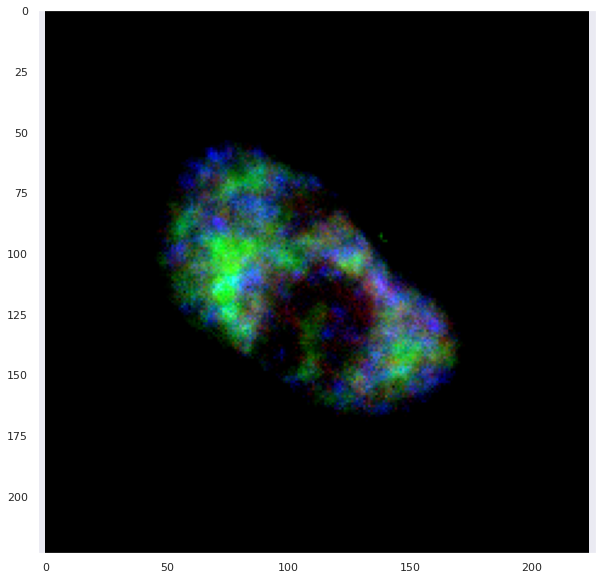

In [22]:
# Get one batch to print a cell
temp_cell = next(iter(val_data))

# add an extra dim (like a batch)
plt.figure(figsize=(10,10))
Data_augmentation.visualize_tensor_cell_image(temp_cell['image'])

In [27]:
# Project images into scalars (using the cell mask)

projected_data_df = pd.DataFrame()
for key in dataset.keys():
    for temp_cell in dataset[key]:
        # get cell features
        cell_id = temp_cell['mapobject_id_cell'].numpy()
        cell_id = int(cell_id.decode())
        target = temp_cell['target'].numpy()[0]
        cell_img = temp_cell['image'].numpy()[:,:,input_ids]
        cell_mask = temp_cell['image'].numpy()[:,:,cell_mask_id]
        cell_mask = cell_mask.astype(np.bool)
        
        # get channel projections
        channel_avg = cell_img[cell_mask].mean(axis=0).reshape((1,-1))
        temp_df = pd.DataFrame(channel_avg, columns=selected_channels)
        temp_df['Y'] = target
        temp_df['mapobject_id_cell'] = cell_id
        
        projected_data_df = pd.concat((projected_data_df, temp_df), axis=0, ignore_index=True)
        
# join metadata and projected values
metadata_df = metadata_df.merge(projected_data_df,
                                left_on='mapobject_id_cell',
                                right_on='mapobject_id_cell',
                                how='left'
                               )
metadata_df

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,cell_size_ratio,set,00_DAPI,07_H2B,01_CDK9_pT186,03_CDK9,05_GTF2B,07_SETD1A,08_H3K4me3,09_SRRM2,10_H3K27ac,11_KPNA2_MAX,12_RB1_pS807_S811,13_PABPN1,14_PCNA,15_SON,16_H3,17_HDAC3,19_KPNA1_MAX,20_SP100,21_NCL,01_PABPC1,02_CDK7,03_RPS6,05_Sm,07_POLR2A,09_CCNT1,10_POL2RA_pS2,11_PML,12_YAP1,13_POL2RA_pS5,15_U2SNRNPB,18_NONO,20_ALYREF,21_COIL,Y
0,373506,373535,plate01,I09,0,0,0,0,6,0,plate01,I09,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12969.0,0.687500,train,0.122234,0.005411,0.309659,0.331320,0.210918,0.262703,0.213745,0.171232,0.324491,0.135966,0.140377,0.073554,0.204744,0.166335,-0.038805,0.243621,0.413020,0.095551,0.188134,0.281889,0.103190,0.200223,0.156326,0.287638,0.314224,0.216244,0.087091,-0.040062,0.099602,0.191125,0.089990,-0.000082,0.124616,599.449219
1,373507,373536,plate01,I09,0,0,0,0,7,0,plate01,I09,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,9846.0,0.598214,val,0.064543,0.317126,0.031180,-0.008400,-0.033492,0.041686,0.024655,0.096202,0.047300,0.047042,-0.052555,0.002146,-0.076506,0.114207,0.341944,0.026892,0.107006,0.035963,0.164858,-0.028328,0.062206,0.013173,0.028374,0.024948,-0.044032,0.061238,0.084620,0.007168,0.179924,-0.015354,0.037083,0.176785,0.057311,398.334869
2,373508,373537,plate01,I09,0,0,0,0,8,0,plate01,I09,0,0,0,0,8,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,7714.0,0.500000,test,0.134224,0.270166,0.236174,0.259591,0.273296,0.297367,0.283451,0.180248,0.111777,0.338557,0.046537,0.211290,0.269006,0.178643,0.288983,0.413877,0.516003,0.147883,0.267621,0.459984,0.170810,0.450180,0.326910,0.341988,0.282028,0.122179,0.158630,0.528339,0.247714,0.243714,0.233957,0.260783,0.233224,464.431671
3,373509,373538,plate01,I09,0,0,0,0,9,0,plate01,I09,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,15718.0,0.678571,val,0.122780,0.064297,0.138513,0.101283,0.085332,0.137869,0.088212,0.122089,0.335367,0.053200,0.081858,0.021767,0.195667,0.094382,0.018904,0.071381,0.146326,0.047480,0.135486,0.050984,0.120236,0.059684,0.069088,0.168350,0.083714,0.038347,0.038024,-0.196788,0.058624,0.031957,-0.043024,-0.030950,-0.012065,425.533325
4,373510,373539,plate01,I09,0,0,0,0,10,0,plate01,I09,0,0,0,0,10,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12229.0,0.633929,train,-0.062693,0.183665,0.151367,0.151057,0.066364,0.095704,0.058824,0.091394,0.071010,0.222309,0.177008,0.039656,0.226743,0.133617,0.197908,0.185380,0.280879,0.100121,0.219005,0.069467,0.016931,0.105712,0.169591,0.125051,0.161972,0.067219,0.130502,0.161687,0.191080,0.085248,0.081374,0.216578,0.092381,410.540771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,248051,248096,plate01,I09,5,4,0,0,31,0,plate01,I09,5,4,0,0,31,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,11135.0,0.571429,train,-0.017233,-0.061294,0.039631,0.064758,0.038310,0.075121,0.059020,0.076885,-0.067685,-0.073536,-0.372721,0.033076,0.026534,0.105601,-0.068191,-0.048906,-0.040903,0.060402,0.091051,0.028095,0.069561,0.023164,0.056582,0.081411,0.104815,-0.077607,0.072436,0.221774,-0.127855,0.027647,-0.084049,-0.071986,-0.026824,325.157349
558,248052,248097,plate01,I09,5,4,0,0,32,0,plate01,I09,5,4,0,0,32,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,13562.0,0.625000,test,-0.088147,-0.052500,-0.030805,-0.045072,-0.062197,0.034918,-0.045863,0.077602,-0.088999,-0.095448,0.005432,0.007972,-0.033040,0.115846,-0.031682,-0.066322,-0.078823,0.075547,0.108090,0.022809,-0.023820,-0.040642

In [30]:
# Create masks for train, val, cv (cv = train + val) and test
mask_train = (metadata_df['set'] == 'train')
print(np.sum(mask_train))

mask_val = (metadata_df['set'] == 'val')
print(np.sum(mask_val))

mask_test = (metadata_df['set'] == 'test')
print(np.sum(mask_test))

mask_cv = mask_train | mask_val

449
56
57


In [ ]:
# Get some necessary stuff for data preprocessing (projection tensor to filter the input channels)
input_shape = np.array(ds_info.features['image'].shape)
projection_tensor = Data_augmentation.get_projection_tensor(input_shape, input_ids)

# Prepare train and validation datasets
train_data, val_data = Data_augmentation.prepare_train_and_val_TFDS(train_data,
                                                                    val_data,
                                                                    projection_tensor,
                                                                    p)

# 3.- Model Selection

Models are selected from a group of predefined models in the class `Predef_models` (in `Models.py`). The name of the selected model is specified in the parameter `p['model_method']`.

First we need to init the `Predef_models` class:

In [ ]:
img_shape = ds_info.features['image'].shape[:-1] + (input_ids.shape[0],)

# init model class
temp_run = Individual_Model_Training()

# init model architectur
temp_run.init_model(arch_name=p['model_name'],
                    input_shape=img_shape,
                    conv_reg=p['conv_reg'],
                    dense_reg=p['dense_reg'],
                    bias_l2_reg=p['bias_l2_reg'],
                    pre_training=p['pre_training'],
                    return_custom_model=p['custom_model_class']
                   )

# select loss function and build the model
temp_run.build_model(loss_name=p['loss'], learning_rate=p['learning_rate'])

### Set model callbacks

In [ ]:
# Callback to print train progren in log file
train_progress_to_log = train_progress_to_log_CB(p['number_of_epochs'])
temp_run.callbacks.append(train_progress_to_log)

# tensorboard callbacks
if p['tensorboard']:
    tensorboard = set_tensorboard_CB(log_path=p['log_path'], log_dir_name=p['model_name'])
    temp_run.callbacks.append(tensorboard)

# set Center moving average callback
avg_sizes = [11, 21, 31]
monitor='val_mean_absolute_error'
loss_CMA = CMA_CB(monitor, avg_sizes)
temp_run.callbacks.append(loss_CMA)

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', 
                                              mode='min', 
                                              patience=p['early_stop_patience'],
                                              min_delta=0,
                                              restore_best_weights=False,
                                              verbose=1
                                             )
temp_run.callbacks.append(early_stop)

# print loaded callbacks
msg = 'Loaded callbacks:\n{}'.format(temp_run.callbacks)
printc(msg)

### Fit the model

In [ ]:
temp_run.fit_model(train_data, val_data, p['number_of_epochs'], p['verbose_level'])

### Plot Loss

In [ ]:
# rename some vars to make it easier
history = temp_run.history.history
metrics = temp_run.metrics

In [ ]:
utils.plot_train_metrics(history=history, metrics=['loss']+metrics, p=p, figsize=(15,23))

In [ ]:
msg = 'Saiving trained model'
logging.info(msg)

# Save history
with open(os.path.join(base_path, 'history.json'), 'w') as file:
    json.dump(history, file, indent=4)
    
# Save CMA history
# First wee need to convert from np.int64 and np.float64 to regular python int and float
temp_dict = {}
for key in loss_CMA.CMA_history.keys():
    temp_dict[key] = [[int(item[0]), float(item[1])] for item in loss_CMA.CMA_history[key]]
with open(os.path.join(base_path, 'CMA_history.json'), 'w') as file:
    json.dump(temp_dict, file, indent=4)
    
# Save parameters
with open(os.path.join(base_path, 'parameters.json'), 'w') as file:
    json.dump(p, file, indent=4)

In [ ]:
# Load history
#path = ''
#with open(os.path.join(path, 'history.json'), 'r') as file:
#    history = json.load(file)
# Save parameters
#with open(os.path.join(base_path, 'parameters.json'), 'r') as file:
#    p = json.load(file)
#metrics = ['mse', 'mean_absolute_error']

# Model evaluation

In [ ]:
# Create data frame to save model metrics
metrics_df = pd.DataFrame()

## 1.- Last model

In [ ]:
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor, tfds_metadata['metadata_df'])
model_eval.targets_df.head()

In [ ]:
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics()
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 2.- Best model with no Center Moving Average (CMA_0)

In [ ]:
eval_name='CMA_0'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor, tfds_metadata['metadata_df'])
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         metrics=['mean_absolute_error'], 
                         p=p,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=0, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 3.- Best model wrt Central Moving Average of size 11 (CMA_11)

In [ ]:
eval_name='CMA_11'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor, tfds_metadata['metadata_df'])
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         CMA_history=loss_CMA.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=11, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 4.- Best model wrt Central Moving Average of size 21 (CMA_21)

In [ ]:
eval_name='CMA_21'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor, tfds_metadata['metadata_df'])
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         CMA_history=loss_CMA.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=21, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

## 5.- Best model wrt Central Moving Average of size 31 (CMA_31)

In [ ]:
eval_name='CMA_31'
# Load weights
temp_run.model.set_weights(loss_CMA.best_models[eval_name][3])
# Save model
temp_run.model.save(os.path.join(model_path, eval_name))
# Evaluate model
model_eval = evaluate_model(p, temp_run.model, projection_tensor, tfds_metadata['metadata_df'])
# Save model data (y_hat values and metrics)
model_eval.save_model_evaluation_data(base_path, eval_name=eval_name)
model_eval.targets_df.head()

In [ ]:
# Loss plot
utils.plot_train_metrics(history=history, 
                         CMA_history=loss_CMA.CMA_history[eval_name],
                         CMA_metric='mean_absolute_error',
                         metrics=['mean_absolute_error'], 
                         p=p,
                         title=eval_name,
                         figsize=(15,23))
# Error distribution plot
sets = ['train','val']
model_eval.plot_error_dist(figsize=(18,6), sets=sets)
# y and y_hat distribution plot
model_eval.plot_y_dist(figsize=(15,7), sets=sets)
# Residuals plot
model_eval.plot_residuals(figsize=(10,7), sets=sets)
# Target vs predicted
model_eval.plot_y_vs_y_hat(figsize=(7.6,7), sets=sets)

In [ ]:
model_eval.get_metrics(CMA_size=31, 
                       CMA=loss_CMA.best_models[eval_name][1], 
                       CMA_Std=loss_CMA.best_models[eval_name][2], 
                       Epoch=loss_CMA.best_models[eval_name][0])
metrics_df = metrics_df.append(model_eval.metrics_df, ignore_index=True)
mask = model_eval.metrics_df.Set == 'test'
model_eval.metrics_df[~mask]

# Compare metrics

In [ ]:
mask = metrics_df.Set == 'test'
metrics_df[~mask]

In [ ]:
mask = metrics_df.Set == 'val'
metrics_df[mask].sort_values(by=['MAE', 'Bias', 'Std'])

In [ ]:
# Save metrics
with open(os.path.join(base_path, 'metrics.csv'), 'w') as file:
    metrics_df.to_csv(file, index=False)

# Save a copy into a common dir to comparation among models
temp_path = os.path.join(p['model_path'], 'Model_Metrics_RI_2')
os.makedirs(temp_path, exist_ok=True)
with open(os.path.join(temp_path, p['basename']+'.csv'), 'w') as file:
    metrics_df.to_csv(file, index=False)

In [ ]:
msg = 'Notebook execution finished!'
logging.info(msg)